In [1]:
import BLSTM_ATT
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Get data

In [2]:
data = pd.read_csv('./DATA/rdata.csv').iloc[:,1:]

inflow, control, outflow, state =[], [], [], []
i = 0
for k in data.columns:
    if '进水' in k:
        inflow.append(i)
    elif 'DO' in k:
        control.append(i)
    elif '出水' in k:
        outflow.append(i)
    else:
        state.append(i)
    i += 1

title = {
    'inflow':inflow, # 进水
    'control':control, # set point of DO
    'state':state, # pool data
    'outflow':outflow,
}
input_index = title['inflow']+title['control']+title['state']
output_index = title['outflow']

In [3]:
step=10 # HRT
xtrain, ytrain=[], []
select = [i for i in range(0,data.shape[0]-step,int(step/2))]
for k in select:
    for i in range(k):
        xtrain.append(data.values[i:i+step,input_index].tolist())
        ytrain.append(data.values[i+1+step,output_index].tolist())
xtrain = Variable(torch.FloatTensor(xtrain))
ytrain = Variable(torch.FloatTensor(ytrain))
print(xtrain.shape,ytrain.shape)

torch.Size([2480, 10, 20]) torch.Size([2480, 5])


# Attention

## 训练

In [8]:
param={
    'embedding_dim':xtrain.shape[2], 
    'num_hiddens':50, 
    'windowsize':xtrain.shape[1],
    'num_layers':4,
    'output_dim':ytrain.shape[1], 
    'learning_rate':0.001,
    'opt':'Adam',
    }
np.save('./model/BLSTM_ATT_param.npy',param)

Net(
  (encoder): LSTM(20, 50, num_layers=4, batch_first=True, bidirectional=True)
  (decoder): Linear(in_features=100, out_features=5, bias=True)
)


e:\anaconda3\envs\tensorflow-cpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


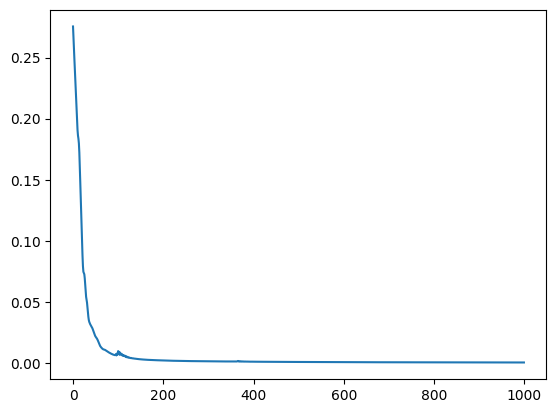

In [ ]:
net = BLSTM_ATT.Net(param)
mse=[]
#net.model = torch.load('./model/BLSTM_ATT')
print(net)
optimizer = torch.optim.Adam(net.parameters(),lr = param['learning_rate'])
loss_func = torch.nn.MSELoss()

for t in range(1000):
    output = net(xtrain)
    loss = loss_func(output,ytrain)
    mse.append(loss.detach().numpy())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
torch.save(net,'./model/BLSTM_ATT')  
plt.plot(mse)

In [23]:
torch.save(net,'./model/BLSTM_ATT')  

# 训练并保存训练过程图

In [5]:
net_tem = BLSTM_ATT.Net(param)
net.model = torch.load('./model/BLSTM_ATT')
print(net_tem)
optimizer = torch.optim.Adam(net_tem.parameters(),lr = param['learning_rate'])
loss_func = torch.nn.MSELoss()
mse,vmse=[],[]
indt, indv = [i for i in range(int(xtrain.shape[0]*0.7))], [i for i in range(int(xtrain.shape[0]*0.7),int(xtrain.shape[0]))]#[np.abs(int(i)) for i in (np.random.randn(int(x.shape[0]*0.7))*x.shape[0])]
xt, yt = xtrain[indt], ytrain[indt]
xv, yv = xtrain[indv], ytrain[indv]
for t in range(1000):
    output = net_tem(xtrain)
    loss = loss_func(output,ytrain)
    
    vp = net_tem(xv)
    lossv = loss_func(vp,yv)
        
    mse.append(loss.detach().numpy())
    vmse.append(lossv.detach().numpy())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Net(
  (encoder): LSTM(20, 50, num_layers=4, batch_first=True, bidirectional=True)
  (decoder): Linear(in_features=100, out_features=5, bias=True)
)


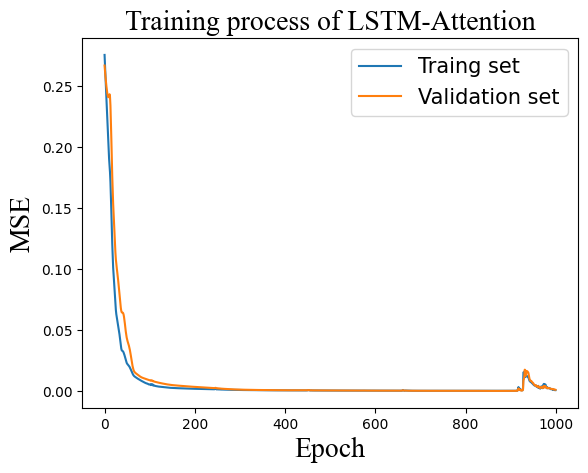

In [6]:
font1={'family':'Times New Roman','weight':'normal','size':20}
font2={'family':'Times New Roman','weight':'normal','size':10}

plt.plot(mse,label='Traing set')
plt.plot(vmse,label='Validation set')
plt.title('Training process of LSTM-Attention',font=font1)
plt.xlabel('Epoch',font=font1)
plt.ylabel('MSE',font=font1)
plt.legend(prop = {'size':15})
plt.savefig('./fig7-c.tif',bbox_inches = 'tight',dpi=200)

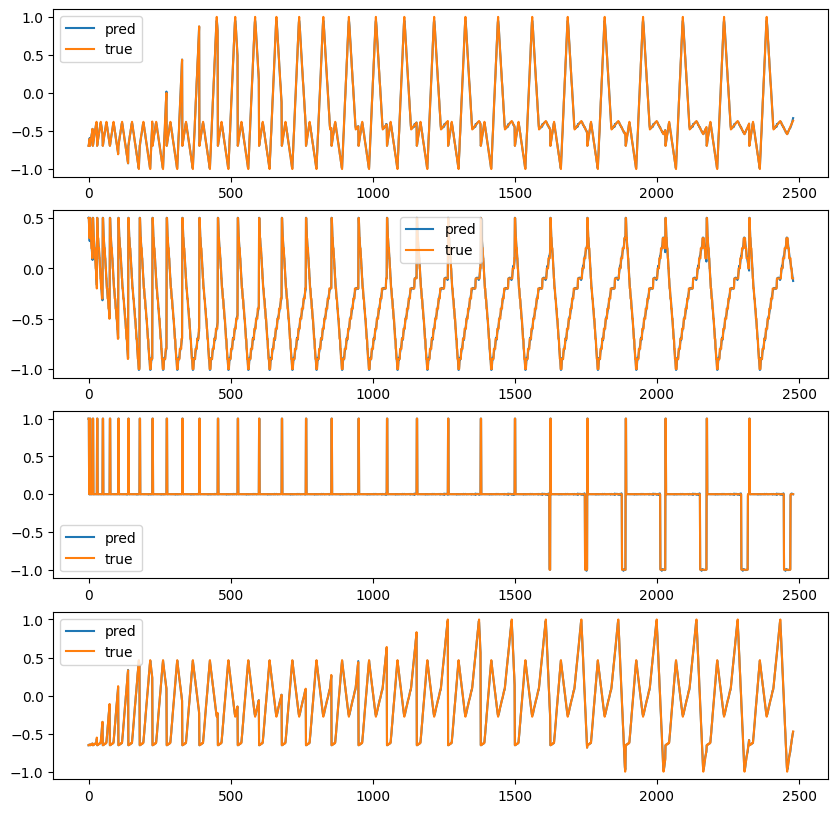

In [24]:
net_tem = BLSTM_ATT.Net(param)
net_tem = torch.load('./model/BLSTM_ATT')
yp = net_tem(xtrain)
fig,ax=plt.subplots(4,1,figsize=(10,10))
for i in range(4):
    ax[i].plot(yp.detach().numpy()[:,i],label='pred')
    ax[i].plot(ytrain.detach().numpy()[:,i],label='true')
    ax[i].legend()